# CBAM Attention Model Testing on Tiny ImageNet

This notebook tests a CNN model with CBAM (Convolutional Block Attention Module) on the Tiny ImageNet dataset, following the same structure as the baseline CNN implementation.


In [1]:
# Import necessary libraries
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import requests
import zipfile
import shutil
from tqdm.notebook import tqdm

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda:0


In [2]:
def prepare_tiny_imagenet():
    """Prepare the Tiny ImageNet dataset for PyTorch"""
    # Define transforms
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(64, padding=4),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Paths to the data
    data_dir = './data/tiny-imagenet-200'
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    
    # Reorganize validation data if needed
    val_img_dir = os.path.join(val_dir, 'images')
    if os.path.exists(val_img_dir):
        print("Reorganizing validation data...")
        val_dict = {}
        with open(os.path.join(val_dir, 'val_annotations.txt'), 'r') as f:
            for line in f.readlines():
                parts = line.strip().split('\t')
                val_dict[parts[0]] = parts[1]
                
        # Create class directories
        for class_id in set(val_dict.values()):
            os.makedirs(os.path.join(val_dir, class_id), exist_ok=True)
            
        # Move images to their respective class directories
        for img, class_id in tqdm(val_dict.items(), desc="Organizing validation images"):
            if os.path.exists(os.path.join(val_img_dir, img)):
                shutil.move(os.path.join(val_img_dir, img), 
                         os.path.join(val_dir, class_id, img))
        
        # Remove the images directory if it's empty
        if os.path.exists(val_img_dir) and len(os.listdir(val_img_dir)) == 0:
            os.rmdir(val_img_dir)
    
    # Create datasets
    print("Creating datasets...")
    trainset = datasets.ImageFolder(train_dir, transform=transform_train)
    valset = datasets.ImageFolder(val_dir, transform=transform_val)
    
    # Create data loaders
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=4)
    
    class_names = trainset.classes
    
    print(f"Dataset loaded with {len(trainset)} training images and {len(valset)} validation images.")
    print(f"Number of classes: {len(class_names)}")
    
    return trainloader, valloader, class_names

# Prepare data loaders
trainloader, valloader, class_names = prepare_tiny_imagenet()

Creating datasets...
Dataset loaded with 100000 training images and 10000 validation images.
Number of classes: 200


## Define Baseline CNN Model


In [3]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(out)
        return self.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_att = ChannelAttention(in_planes, ratio)
        self.spatial_att = SpatialAttention(kernel_size)
        
    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

class CBAM_CNN(nn.Module):
    def __init__(self, num_classes=200):
        super(CBAM_CNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            CBAMBlock(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            CBAMBlock(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            CBAMBlock(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAMBlock(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Example instantiation
model = CBAM_CNN(num_classes=200)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

CBAM_CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): CBAMBlock(
      (channel_att): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU()
        (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (sigmoid): Sigmoid()
      )
      (spatial_att): SpatialAttention(
        (conv1): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (sigmoid): Sigmoid()
      )
    )
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tru

## Training and Evaluation Functions


In [4]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(preds == labels.data).item()
        processed_size += batch_size
    
    epoch_loss = running_loss / processed_size
    epoch_acc = running_corrects / processed_size
    
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels.data).item()
            processed_size += batch_size
    
    epoch_loss = running_loss / processed_size
    epoch_acc = running_corrects / processed_size
    
    return epoch_loss, epoch_acc

## Train Model


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Number of epochs
num_epochs = 30

# Initialize variables
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
since = time.time()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    # Train and evaluate
    train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, valloader, criterion)
    
    # Update learning rate
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'model/cbam/best_model.pth')
        print(f'New best model saved with accuracy: {best_acc:.4f}')
    
    print()

# Calculate training time
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val accuracy: {best_acc:.4f}')

# Load best model
model.load_state_dict(best_model_wts)

Epoch 1/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

## Visualize Results


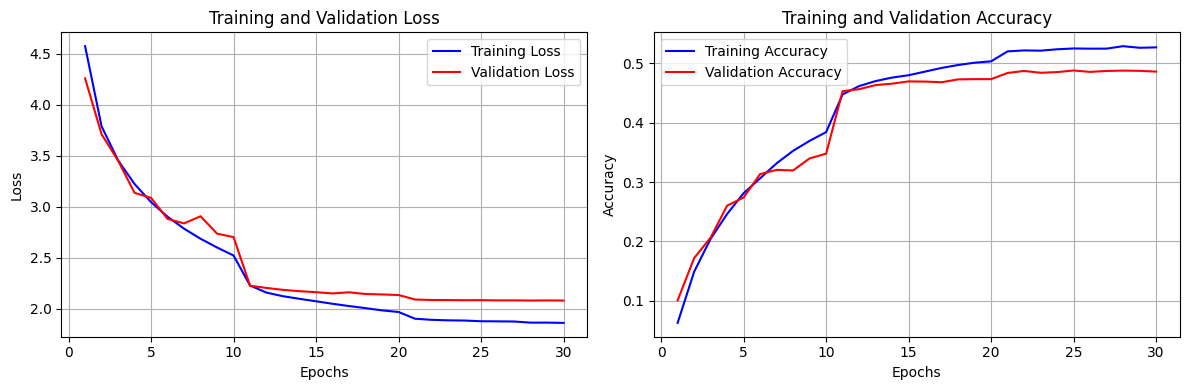

In [6]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), history['train_loss'], 'b-', label='Training Loss')
plt.plot(range(1, num_epochs+1), history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), history['train_acc'], 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs+1), history['val_acc'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

## Class-wise Performance


In [7]:
def get_class_accuracies(model, dataloader, class_names):
    """Calculate per-class accuracies"""
    model.eval()
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Calculating class accuracies"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            correct = (preds == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
    # Calculate accuracies
    class_accuracies = {}
    for i in range(len(class_names)):
        if class_total[i] > 0:
            class_accuracies[class_names[i]] = class_correct[i] / class_total[i]
    
    return class_accuracies

# Get class accuracies
class_accuracies = get_class_accuracies(model, valloader, class_names)

# Print overall accuracy
overall_acc = sum(class_accuracies.values()) / len(class_accuracies)
print(f"Overall accuracy: {overall_acc:.4f}")

# Find best and worst classes
best_classes = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)[:5]
worst_classes = sorted(class_accuracies.items(), key=lambda x: x[1])[:5]

print("\nBest performing classes:")
for cls, acc in best_classes:
    print(f"{cls}: {acc:.4f}")

print("\nWorst performing classes:")
for cls, acc in worst_classes:
    print(f"{cls}: {acc:.4f}")

Calculating class accuracies:   0%|          | 0/79 [00:00<?, ?it/s]

Overall accuracy: 0.4879

Best performing classes:
n02074367: 0.8600
n02279972: 0.8400
n07920052: 0.8400
n01768244: 0.8200
n03837869: 0.8200

Worst performing classes:
n03970156: 0.0600
n04507155: 0.0800
n04597913: 0.1000
n03976657: 0.1200
n02909870: 0.1400


## Save and Load Model


In [10]:
# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': best_acc,
    'history': history
}, 'model/cbam/final_model.pth')

print("Model saved to 'final_model.pth'")

RuntimeError: Parent directory model/cbam does not exist.

In [ ]:
# Example of how to load the model
def load_model(model_path, model_class, num_classes):
    # Initialize model
    model = model_class(num_classes=num_classes)
    
    # Load checkpoint
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    return model, checkpoint

# Example usage (commented out to avoid execution)
# loaded_model, checkpoint = load_model('final_model.pth', BaselineCNN, len(class_names))
# print(f"Loaded model with validation accuracy: {checkpoint['val_acc']:.4f}")

## Conclusion

This notebook has established a baseline CNN model for the Tiny ImageNet dataset. You can use this as a foundation for more advanced architectures and experiments in your final project.

### Next Steps:

1. Try different architectures (VGG, ResNet, etc.)
2. Experiment with various hyperparameters (learning rate, batch size, etc.)
3. Implement attention mechanisms
4. Explore different optimization techniques
5. Use more advanced regularization methods
6. Test various data augmentation strategies
